# Rank-based Tests

### 1 Rank


Let $x_{(1)},x_{(2)},\dots,x_{(n)}$ denote the ordered sample.  The **rank** of an observation $x_i$ is  

$$R_i \;=\; 1 + \#\{\,x_j : x_j < x_i\, j \neq i\}.$$


### 2 Parametric Tests v.s. Nonparametric Tests

Parametric tests require parametric assumptions (e.g., normal errors for t-tests), while nonparametric tests avoid parametric assumptions. As a result, for the same or similar hypotheses, parametric tests are more efficient when the assumptions are true (as they incoporate additional information), while the nonparametric tests sacrifice efficiency for robustness to violation of such assumptions.

We will compare a t-test and a Wilcoxon test in the following simulation study. We generate data are drawn from a Student-$t$ distribution in a range of settings:
- degrees-of-freedom ${\rm df} = \infty, 30, 15, 10, 5, 3$  
- zero mean under the null and mean = 0.6 under the alternative.    
Here at ${\rm df}=\infty$, it behaves exactly like a standard normal. A smaller ${\rm df}$ yields heavier tails.

The Wilcoxon signed-rank test is for testing the null hypothesis  
$$H_0: \text{The distribution of sample is symmetric about } 0$$ 
against the alternative that the distribution is not symmetric about $0$.  Let $X_1,\dots,X_n$ be the sample and let $m_0$ be the hypothesised median . Form the differences $D_i = X_i - m_0$ and discard any zeros.  Suppose $n'$ non-zero differences remain.

1. Compute the absolute values $|D_i|$ and assign them ranks $R_i$ from $1$ to $n'$ (average ranks for ties).
2. Attach the original signs $\operatorname{sgn}(D_i)$ to those ranks.
3. Sum the positive signed ranks:
$$
W \;=\; \sum_{i=1}^{n'} R_i \,\mathbf{1}\!\bigl(D_i>0\bigr)
$$
When sample size is sufficiently large, we have  
$$ Z \;=\; \frac{W - E[W]}{\sqrt{\operatorname{Var}(W)}} 
  \;\;\xrightarrow{d}\;\; \mathcal{N}(0,1).$$


Here we choose sample size $n = 25$ and the nominal significance level $\alpha = 0.05$.  For each ${\rm df}$ we simulate $5000$ replicates and compute  
- Type I error rate: fraction of $p < \alpha$ under $H_0$.  
- Power:  fraction of $p < \alpha$ under $H_1$.  


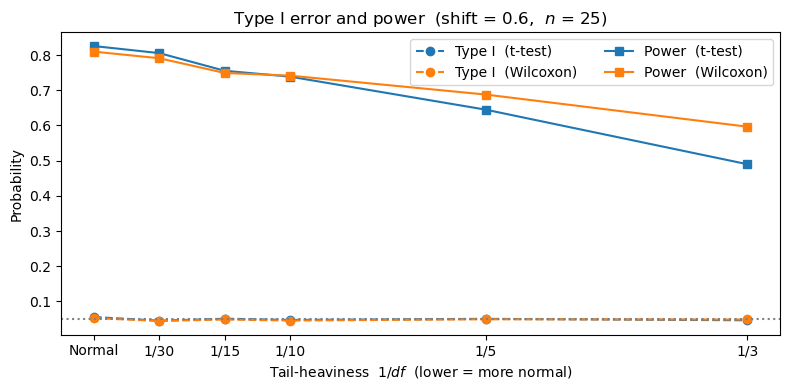

In [2]:
import numpy as np, scipy.stats as st, matplotlib.pyplot as plt

rng     = np.random.default_rng(42)
n       = 25           # sample size
alpha   = 0.05
reps    = 5000
shift   = 0.6          # mean shift under H1
dfs     = [np.inf, 30, 15, 10, 5, 3]   # ∞ ≈ normal

type1_t = []; type1_w = []
power_t = []; power_w = []

for df in dfs:
    # ---------- simulate under H0 ----------
    if np.isinf(df):
        x0 = rng.normal(0, 1, (reps, n))
        x1 = rng.normal(shift, 1, (reps, n))
    else:
        x0 = rng.standard_t(df, (reps, n))
        x1 = rng.standard_t(df, (reps, n)) + shift

    # vectorised t-test p-values
    t0 = x0.mean(1) / (x0.std(1, ddof=1) / np.sqrt(n))
    p_t0 = 2 * (1 - st.t.cdf(np.abs(t0), df=n-1))
    type1_t.append((p_t0 < alpha).mean())

    t1 = x1.mean(1) / (x1.std(1, ddof=1) / np.sqrt(n))
    p_t1 = 2 * (1 - st.t.cdf(np.abs(t1), df=n-1))
    power_t.append((p_t1 < alpha).mean())

    # Wilcoxon (loop per replicate – slower but fine at reps=5000)
    def w_p(mat):                # helper = vector of p-values
        out = []
        for row in mat:
            try:
                out.append(st.wilcoxon(row, zero_method='wilcox').pvalue)
            except ValueError:   # all zeros
                out.append(1.0)
        return np.array(out)

    p_w0 = w_p(x0)
    type1_w.append((p_w0 < alpha).mean())

    p_w1 = w_p(x1)
    power_w.append((p_w1 < alpha).mean())

# ---------- plot ----------
tail = [0 if np.isinf(df) else 1/df for df in dfs]  # 0 = normal

fig, ax = plt.subplots(figsize=(8,4))

# Type I curves (dashed)
ax.plot(tail, type1_t, 'o--', label='Type I  (t-test)',  color='C0')
ax.plot(tail, type1_w, 'o--', label='Type I  (Wilcoxon)', color='C1')
ax.axhline(alpha, ls=':', color='grey')

# Power curves (solid)
ax.plot(tail, power_t, 's-',  label='Power  (t-test)',   color='C0')
ax.plot(tail, power_w, 's-',  label='Power  (Wilcoxon)', color='C1')

ax.set_xticks(tail)
ax.set_xticklabels(['Normal']+[f'1/{df}' for df in dfs[1:]])
ax.set_xlabel('Tail-heaviness  $1/df$  (lower = more normal)')
ax.set_ylabel('Probability')
ax.set_title(fr'Type I error and power  (shift = {shift},  $n$ = {n})')
ax.legend(ncol=2)
plt.tight_layout()
plt.show()



### 3 Canonical rank-based tests  
| Test | Data structure | Null hypothesis $H_0$ | Test statistic (schematic) | Typical assumptions |
|------|---------------|-------------------------|---------------------------|---------------------|
| **Wilcoxon signed-rank** | One sample (paired) | Median = 0 | $ W = \sum_{i=1}^n R_i^+ $ | Symmetric distribution of differences |
| **Mann–Whitney (Wilcoxon rank-sum)** | Two independent samples | $F_X = F_Y$ | $ U = \sum_{i=1}^{n_X} R_i - \tfrac{n_X(n_X+1)}2 $ | Continuous, independent samples |
| **Kruskal–Wallis** | ≥ 2 groups | All group medians equal | $ H = \frac{12}{N(N+1)} \sum_{g} \frac{R_g^2}{n_g} - 3(N+1) $ | Independent samples, similar shape |
| **Spearman ρ** | Two numeric vectors | No monotone association | $ \rho_s = 1 - \frac{6\sum d_i^2}{n(n^2-1)} $ | Continuous ranks, independence |

*$R_i^+$  = ranks of positive differences;  $R_g$ = sum of ranks in group *g*.*

